In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import os
from transformers import pipeline
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import spacy
from fuzzywuzzy import fuzz
import warnings

In [99]:
df_tweets = pd.read_csv('/Users/yassinkortam/Documents/GitHub/segmentation-pipeline/data/tweets/tokyo_2020_tweets.csv', low_memory=False).sample(n=10000, replace=False, random_state=42)
df_athletes = pd.read_excel('/Users/yassinkortam/Documents/GitHub/segmentation-pipeline/data/olympics/Athletes.xlsx')
df_medals = pd.read_excel('/Users/yassinkortam/Documents/GitHub/segmentation-pipeline/data/olympics/Medals.xlsx')
df_tweets.shape

(10000, 16)

# Preparing the Olympics Datasets
The medals dataset will be used to sort the athletes dataset. Only the athletes dataset, renamed to df_merged, will be used in analysis. It does not need to be cropped because regex pattern matching will be used later to narrow down atheletes according to frequency of mentions in tweets.

In [100]:
df_medals.sort_values(by='Rank', ascending=True)

,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total
0,1,United States of America,39,41,33,113,1
1,2,People's Republic of China,38,32,18,88,2
2,3,Japan,27,14,17,58,5
3,4,Great Britain,22,21,22,65,4
4,5,ROC,20,28,23,71,3
...,...,...,...,...,...,...,...
91,86,Republic of Moldova,0,0,1,1,77
86,86,Burkina Faso,0,0,1,1,77
85,86,Botswana,0,0,1,1,77
87,86,Côte d'Ivoire,0,0,1,1,77


In [101]:
df_athletes.head(3)

,Name,NOC,Discipline
0,AALERUD Katrine,Norway,Cycling Road
1,ABAD Nestor,Spain,Artistic Gymnastics
2,ABAGNALE Giovanni,Italy,Rowing


In [102]:
df_merged = df_medals.merge(df_athletes, left_on='Team/NOC', right_on='NOC').drop(columns=df_medals.columns)
df_merged

,Name,NOC,Discipline
0,ABBOTT Monica,United States of America,Baseball/Softball
1,ABDIRAHMAN Abdi,United States of America,Athletics
2,ADEBAYO Edrice Femi,United States of America,Basketball
3,AGUILAR Ali,United States of America,Baseball/Softball
4,AHSINGER Nicole,United States of America,Trampoline Gymnastics
...,...,...,...
10213,GHAZAL Majd Eddin,Syrian Arab Republic,Athletics
10214,HAMCHO Ahmad Saber,Syrian Arab Republic,Equestrian
10215,KELZI Ayman,Syrian Arab Republic,Swimming
10216,MASO Mohamad,Syrian Arab Republic,Triathlon


# Preparing the Tweets Dataset
- Some datatypes are incorrectly casted to string, so that must be corrected for analysis.

In [103]:
df_tweets.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
146339,1419897690595348490,Whateley,"Melbourne, Australia",Official Twitter account of @1116SEN morning s...,2015-02-26 01:19:55,20151,707,8,False,2021-07-27 05:49:24,LISTEN | Catch up on all of today's #Tokyo2020...,['Tokyo2020'],TweetDeck,1.0,3.0,False
119470,1419662387913781248,Ιούλιος Καίσαρας,NaN,🔞NSFW!🔞,2013-10-18 12:07:11,130,1335,101628,False,2021-07-26 14:14:23,i literally cried congratulations hidilyn diaz...,NaN,Twitter for iPhone,0.0,0.0,False
66665,1419340754544177164,canadianbestseller.com,NaN,https://t.co/ZJK4Q3dy6l – Your Prime Discount ...,2019-10-26 02:56:57,33,334,10,False,2021-07-25 16:56:20,#buy Yoga Mat (183x80x1cm) Extra Thick Wide N...,"['buy', 'DOISPON']",Sharious.com,0.0,0.0,False


In [104]:
df_tweets.dtypes

id                   object
user_name            object
user_location        object
user_description     object
user_created         object
user_followers       object
user_friends         object
user_favourites      object
user_verified        object
date                 object
text                 object
hashtags             object
source               object
retweets            float64
favorites           float64
is_retweet           object
dtype: object

In [105]:
df_tweets.dropna(inplace=True)
df_tweets['user_created'] = df_tweets['user_created'].astype('datetime64[ns]')
df_tweets['date'] = df_tweets['date'].astype('datetime64[ns]')
df_tweets['user_followers'] = df_tweets['user_followers'].astype('int64')
df_tweets['user_friends'] = df_tweets['user_friends'].astype('int64')
df_tweets['user_favourites'] = df_tweets['user_favourites'].astype('int64')
df_tweets['user_verified'] = df_tweets['user_verified'].astype('bool')
df_tweets['retweets'] = df_tweets['retweets'].astype('int64')
df_tweets['favorites'] = df_tweets['favorites'].astype('int64')
df_tweets['is_retweet'] = df_tweets['is_retweet'].astype('bool')
df_relevant_tweets = df_tweets.sort_values(by='user_followers', ascending=False).reset_index(drop=True)
df_relevant_tweets.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1419960040031756305,The New York Times,New York City,News tips? Share them here: https://t.co/ghL9O...,2007-03-02 20:41:42,50155607,840,18542,True,2021-07-27 09:57:09,The #Tokyo2020 match between the U.S. and Aust...,['Tokyo2020'],SocialFlow,4,16,False
1,1419946172987359238,The New York Times,New York City,News tips? Share them here: https://t.co/ghL9O...,2007-03-02 20:41:42,50155470,840,18542,True,2021-07-27 09:02:03,The #Tokyo2020 match between the U.S. and Aust...,['Tokyo2020'],SocialFlow,9,52,False
2,1419787148945936384,The New York Times,New York City,News tips? Share them here: https://t.co/ghL9O...,2007-03-02 20:41:42,50154648,837,18542,True,2021-07-26 22:30:09,It's morning in Tokyo for Day 4 of the Summer ...,['Tokyo2020'],SocialFlow,38,156,False
3,1419834687489552390,The New York Times,New York City,News tips? Share them here: https://t.co/ghL9O...,2007-03-02 20:41:42,50154397,839,18542,True,2021-07-27 01:39:03,"Lilly King, the American swimmer, is about to ...",['Tokyo2020'],SocialFlow,18,117,False
4,1419802269596463104,The New York Times,New York City,News tips? Share them here: https://t.co/ghL9O...,2007-03-02 20:41:42,50153922,837,18542,True,2021-07-26 23:30:14,Hoping to catch some #Tokyo2020 action? Here's...,['Tokyo2020'],SocialFlow,10,81,False


## Filtering the Datasets
- The 5 most popular sports out of the 46 will be selected to reduce the complexity of the analysis.
- The 5 most popular countries will be selected to further reduce complexity.
- The athletes that play these sports from these countries will be included in the analysis.

Popularity will be approximated by doing a regex search throughout the dataset. More popular topics are more likely to have regex matches. A more comprehnsive approach would be to tokenize each topic and each word in each tweet and then compare cosine similarity, but that is very ineffcient and slow to do for 10,000+ athletes.

In [106]:
countries = df_merged['NOC'].unique()
athletes = df_merged['Name'].unique()
sports = df_merged['Discipline'].unique()
df_filtered_tweets = pd.DataFrame(columns=df_relevant_tweets.columns)

In [107]:
sports_frequency = {'sport': [], 'frequency': []}
for sport in tqdm(sports):
    sports_frequency['sport'].append(sport)
    search_pattern = sport
    df_matched = df_relevant_tweets[df_relevant_tweets['text'].str.contains(search_pattern, flags=re.IGNORECASE)]
    sports_frequency['frequency'].append(len(df_matched))
sports_frequency = pd.DataFrame(sports_frequency)
popular_sports = sports_frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True).head(5)
popular_sports

  0%|          | 0/46 [00:00<?, ?it/s]

,sport,frequency
0,Swimming,214
1,Tennis,208
2,Hockey,166
3,Skateboarding,135
4,Weightlifting,134


In [108]:
countries_frequency = {'country': [], 'frequency': []}
for country in tqdm(countries):
    if country == 'United States of America':
        country = 'USA'
    if country == 'Great Britain':
        country = 'UK'
    countries_frequency['country'].append(country)
    search_pattern = country
    countries_frequency['frequency'].append(len(df_relevant_tweets[df_relevant_tweets['text'].str.contains(search_pattern, flags=re.IGNORECASE)]))
countries_frequency = pd.DataFrame(countries_frequency)
popular_countries = countries_frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True).head(5)
popular_countries

  0%|          | 0/93 [00:00<?, ?it/s]

,country,frequency
0,India,606
1,USA,345
2,Japan,148
3,Canada,128
4,UK,120


In [109]:
relevant_athletes = df_merged[df_merged['NOC'].isin(popular_countries['country']) & df_merged['Discipline'].isin(popular_sports['sport'])].reset_index(drop=True)
relevant_athletes.head(5)

,Name,NOC,Discipline
0,ANDOH Mikiko,Japan,Weightlifting
1,AOKI Reona,Japan,Swimming
2,AOKI Yukito,Japan,Skateboarding
3,AOYAMA Shuko,Japan,Tennis
4,ASAI Yu,Japan,Hockey


In [110]:
warnings.filterwarnings('ignore')

for country in tqdm(popular_countries['country']):
    search_pattern = country
    df_matched = df_relevant_tweets[df_relevant_tweets['text'].str.contains(search_pattern, flags=re.IGNORECASE)]   
    df_filtered_tweets = pd.concat([df_filtered_tweets, df_matched])

for sport in tqdm(popular_sports['sport']):
    search_pattern = sport
    df_matched = df_relevant_tweets[df_relevant_tweets['text'].str.contains(search_pattern, flags=re.IGNORECASE)]   
    df_filtered_tweets = pd.concat([df_filtered_tweets, df_matched])

df_filtered_tweets.drop_duplicates(inplace=True)
df_filtered_tweets

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
15,1418937764310130697,The Times Of India,New Delhi,News. Views. Analysis. Conversations. India’s ...,2010-04-19 10:50:15,13778503,468,5,True,2021-07-24 14:15:00,#Tokyo2020 #MirabaiChanu #TeamIndia #Cheer4Ind...,"['Tokyo2020', 'MirabaiChanu', 'TeamIndia', 'Ch...",TweetDeck,28,215,False
35,1419818054544855042,ANI,India,Asian News International. Multi-media news age...,2011-08-16 05:23:41,5956992,0,0,True,2021-07-27 00:32:57,#Tokyo2020 | 10m Air Pistol Mixed Team Qualifi...,['Tokyo2020'],Twitter Web App,51,692,False
36,1419921761127178241,IndiaToday,India,"Brings you news breaks: Exclusive political, e...",2009-02-02 07:21:54,5735296,248,4445,True,2021-07-27 07:25:03,#TokyoOlympics: Sharath Kamal loses 4-1 to def...,['TokyoOlympics'],Twitter Web App,3,20,False
38,1419432277172494340,IndiaToday,India,"Brings you news breaks: Exclusive political, e...",2009-02-02 07:21:54,5734174,248,4445,True,2021-07-25 23:00:01,Mary Kom (@MangteC) beats Dominican Republic's...,['IndiaTodayAtOlympics'],Twitter Media Studio,4,25,False
43,1419901228981657601,News18,India,Official Twitter account of CNN-News18. Lightn...,2007-06-01 20:31:01,4585648,403,187,True,2021-07-27 06:03:28,India at #Tokyo2020.\n\nBoxer Lovlina Borgohai...,['Tokyo2020'],Grabyo,1,16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5360,1419636816706109441,Toink,"Andito lang, naghihintay.",Lost. Still.,2018-11-27 03:47:19,27,77,0,True,2021-07-26 12:32:47,"Go get that gold, Hidilyn!!! 💪\n#OlympicGames\...","['OlympicGames', 'Tokyo2020', 'Weightlifting']",Twitter for Android,0,0,False
5366,1419335127482736655,Rao Muhammad Daniyal,Lahore,𝕾𝖙𝖗𝖎𝖛𝖊 𝕬𝖑𝖜𝖆𝖞𝖘 𝖙𝖔 𝖊𝖝𝖈𝖊𝖑 𝖎𝖓 𝖁𝖎𝖗𝖙𝖚𝖊 & 𝕿𝖗𝖚𝖙𝖍...,2019-12-21 14:40:44,26,74,788,True,2021-07-25 16:33:59,Talha Talib acquired 5th position in weightlif...,['Tokyo2020'],Twitter Web App,0,0,False
5393,1419647448956366850,balu biyani,mumbai,born LEO special itself............\nhav cont...,2010-04-04 09:46:29,23,256,15241,True,2021-07-26 13:15:02,#WeightLifting Hight of Expections &amp; Belie...,"['WeightLifting', 'Tokyo2020']",Twitter for Android,0,0,False
5478,1418874336132444167,虹 ``,"exoplanet, exo","Leave me in a peace with exo, sometimes iKON, ...",2021-01-14 15:38:29,12,35,2103,True,2021-07-24 10:02:57,I've got so emotional seeing #BEL woman's 49KG...,"['BEL', 'Weightlifting']",Twitter for Android,0,0,False


# Sentiment Analysis

Sentiment analysis can give brands a sense of what their customer's experience with their products is. Twitter is a very popular outlet for people to voice their opinions, so automatically analyzing a large number of tweets with machine learning can provide valuable insights. In this case, sentiment analysis will be used to identify popular teams, sports, and athletes. 

https://huggingface.co/blog/sentiment-analysis-twitter


In [111]:
model = "cardiffnlp/twitter-roberta-base-sentiment-latest"
classifier = pipeline("sentiment-analysis", model=model)
tweets = df_filtered_tweets['text'].tolist()
tweets_analysis = []
for tweet in tqdm(tweets):
    analysis = classifier(tweet)[0]
    analysis['text'] = tweet
    tweets_analysis.append(analysis)

tweets_analysis = pd.DataFrame(tweets_analysis)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1917 [00:00<?, ?it/s]

In [115]:
tweets_analysis.groupby('label').count()

,score,text
label,,
neutral,1465,1465
positive,452,452


In [116]:
df_positive_tweets = tweets_analysis.groupby('label').get_group('positive').reset_index(drop=True)
df_positive_tweets.sort_values(by='score', ascending=False, inplace=True, ignore_index=True)

df_neutral_tweets = tweets_analysis.groupby('label').get_group('neutral').reset_index(drop=True)
df_neutral_tweets.sort_values(by='score', ascending=False, inplace=True, ignore_index=True)

# df_negative_tweets = tweets_analysis.groupby('label').get_group('negative').reset_index(drop=True)
# df_negative_tweets.sort_values(by='score', ascending=False, inplace=True, ignore_index=True)

## Visualize Commonly used Words in Positive Tweets

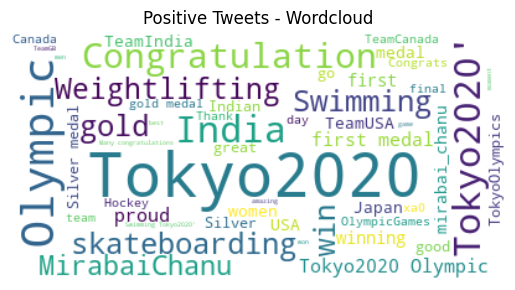

In [117]:
stop_words = ["https", "co", "RT", 't', 's', 'n'] + list(STOPWORDS)

positive_tweets = df_positive_tweets['text'].tolist()

positive_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.figure()
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Associate Countries and Sports with Sentiments

In [119]:
country_sentiments = {
    'country': [], 
    'positive': [], 
    'neutral': [],
    # 'negative':[]
    }
for country in tqdm(popular_countries['country']):
    country_sentiments['country'].append(country)
    country_sentiments['positive'].append(len(df_positive_tweets[df_positive_tweets['text'].str.contains(country, flags=re.IGNORECASE)]))
    country_sentiments['neutral'].append(len(df_neutral_tweets[df_neutral_tweets['text'].str.contains(country, flags=re.IGNORECASE)]))
    # country_sentiments['negative'].append(len(df_negative_tweets[df_negative_tweets['text'].str.contains(country, flags=re.IGNORECASE)]))
country_sentiments = pd.DataFrame(country_sentiments).sort_values(by='positive', ascending=False).reset_index(drop=True)
country_sentiments

  0%|          | 0/5 [00:00<?, ?it/s]

,country,positive,neutral
0,India,134,472
1,USA,64,281
2,Canada,37,91
3,Japan,30,118
4,UK,25,95


In [120]:
sport_sentiments = {
    'sport': [], 
    'positive': [], 
    'neutral': [],
    # 'negative':[]
    }
for sport in tqdm(popular_sports['sport']):
    sport_sentiments['sport'].append(sport)
    sport_sentiments['positive'].append(len(df_positive_tweets[df_positive_tweets['text'].str.contains(sport, flags=re.IGNORECASE)]))
    sport_sentiments['neutral'].append(len(df_neutral_tweets[df_neutral_tweets['text'].str.contains(sport, flags=re.IGNORECASE)]))
    # sport_sentiments['negative'].append(len(df_negative_tweets[df_negative_tweets['text'].str.contains(sport, flags=re.IGNORECASE)]))
sport_sentiments = pd.DataFrame(sport_sentiments).sort_values(by='positive', ascending=False).reset_index(drop=True)
sport_sentiments

  0%|          | 0/5 [00:00<?, ?it/s]

,sport,positive,neutral
0,Swimming,72,142
1,Weightlifting,53,81
2,Skateboarding,45,90
3,Hockey,22,144
4,Tennis,20,188


## Associate Players with Sentiments


In [121]:
def isPerson(name, tweet):
    found = True
    
    # Split the names into first and last names
    name_parts = name.split()
    
    # Check the match for both first and last names
    for part_name in name_parts:
        pattern = re.compile(re.escape(part_name), re.IGNORECASE)
        found = found and bool(pattern.search(tweet))

    return found

player_sentiments = {
    'player': [], 
    'positive': [], 
    'neutral': [],
    # 'negative':[]
    }
for player in tqdm(relevant_athletes['Name']):
    player_sentiments['player'].append(player)

    num_positive = 0
    for tweet in positive_tweets:
        if isPerson(player, tweet):
            num_positive += 1
    player_sentiments['positive'].append(num_positive)
 
    num_neutral = 0
    for tweet in df_neutral_tweets['text']:
        if isPerson(player, tweet):
            num_neutral += 1
    player_sentiments['neutral'].append(num_neutral)

    # num_negative = 0
    # for tweet in df_negative_tweets['text']:
    #     if isPerson(player, tweet):
    #         num_negative += 1
    # player_sentiments['negative'].append(num_negative)

player_sentiments = pd.DataFrame(player_sentiments).sort_values(by='positive', ascending=False).reset_index(drop=True)
player_sentiments.head(5)

  0%|          | 0/176 [00:00<?, ?it/s]

,player,positive,neutral
0,HORIGOME Yuto,4,7
1,NISHIYA Momiji,4,4
2,NAGAL Sumit,2,13
3,SUMIT,2,13
4,SAVITA,1,0


- Yuto Horigome: "Yuto Horigome (堀米 雄斗, Horigome Yūto, born 7 January 1999) is a Japanese professional skateboarder. He won the gold medal in the inaugural Olympic men's street event at the 2020 Summer Olympics, becoming the first person ever to win a gold medal in skateboarding at the Olympics."

- Momiji Nishya: "Momiji Nishiya (西矢 椛, Nishiya Momiji, born 30 August 2007) is a Japanese skateboarder. At the 2020 Summer Olympics, she won the first ever gold medal in the women's street competition. Winning it at 13, she is the youngest person ever to win a gold medal for Japan, and third youngest after Marjorie Gestring and Klaus Zerta to ever win an event at the Summer Olympics."

- Sumit Nagal: "Sumit Nagal (born 16 August 1997) is an Indian professional tennis player. He won the 2015 Wimbledon boys' doubles title with his Vietnamese partner Lý Hoàng Nam, thus becoming the sixth Indian player to win a junior Grand Slam title. He is currently the highest-ranked Indian singles tennis player and since 2018, he has been a regular member of India's national Davis Cup squad."